## 모델 구조 변경모델(더 깊게)

/aiffel/aiffel
5216
624
16
4185
1047
Normal image path
/aiffel/aiffel/chest_xray/data/train/NORMAL/IM-0450-0001.jpeg
Pneumonia image path
/aiffel/aiffel/chest_xray/data/train/PNEUMONIA/person1345_bacteria_3422.jpeg
Normal images count in training set: 1072
Pneumonia images count in training set: 3113
Training images count: 4185
Validating images count: 1047
Image shape:  (180, 180, 3)
Label:  False
Weight for NORMAL: 1.95
Weight for PNEUMONIA: 0.67
Epoch 1/10
261/261 [==============================] - 65s 204ms/step - loss: 0.5251 - accuracy: 0.7227 - precision: 0.9340 - recall: 0.6747 - val_loss: 1.2762 - val_accuracy: 0.7375 - val_precision: 0.7375 - val_recall: 1.0000
Epoch 2/10
261/261 [==============================] - 53s 205ms/step - loss: 0.3451 - accuracy: 0.8278 - precision: 0.9679 - recall: 0.7950 - val_loss: 2.2055 - val_accuracy: 0.7346 - val_precision: 0.7346 - val_recall: 1.0000
Epoch 3/10
261/261 [==============================] - 53s 203ms/step - loss: 0.2991 - accurac

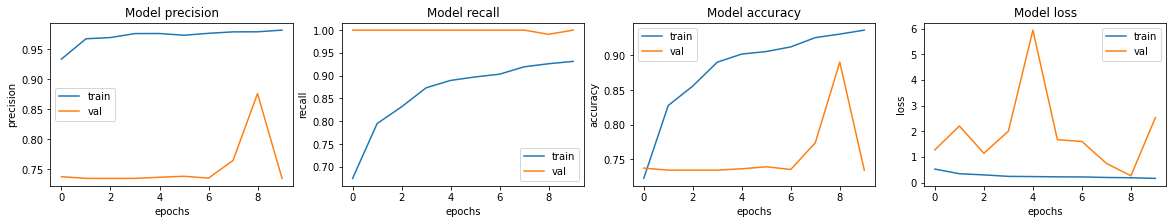

In [10]:
import os, re
import random, math
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import warnings 
warnings.filterwarnings(action='ignore')

# 데이터 병렬 처리 기능 활성화
AUTOTUNE = tf.data.experimental.AUTOTUNE
# X-Ray 이미지를 모델 입력 크기로 변환
IMAGE_SIZE = [180, 180]

# 기본 경로 설정
ROOT_PATH = os.path.join(os.getenv('HOME'), 'aiffel')
# 학습 데이터 경로
TRAIN_PATH = ROOT_PATH + '/chest_xray/data/train/*/*'
# 검증 데이터 경로
VAL_PATH = ROOT_PATH + '/chest_xray/data/val/*/*'
# 테스트 데이터 경로
TEST_PATH = ROOT_PATH + '/chest_xray/data/test/*/*'

# 배치 크기 (학습 성능과 메모리 사용량 조정 가능)
BATCH_SIZE = 16
# 학습 반복 횟수
EPOCHS = 10

print(ROOT_PATH)

# 학습 데이터 파일 경로 읽기
train_filenames = tf.io.gfile.glob(TRAIN_PATH)
# 테스트 데이터 파일 경로 읽기
test_filenames = tf.io.gfile.glob(TEST_PATH)
# 검증 데이터 파일 경로 읽기
val_filenames = tf.io.gfile.glob(VAL_PATH)

# 데이터 개수 출력
print(len(train_filenames))
print(len(test_filenames))
print(len(val_filenames))

# train과 val 데이터 통합 후 나누기
filenames = tf.io.gfile.glob(TRAIN_PATH)
filenames.extend(tf.io.gfile.glob(VAL_PATH))

# 8:2로 데이터 분할
train_size = math.floor(len(filenames)*0.8)
random.seed(8)
random.shuffle(filenames)

train_filenames = filenames[:train_size]
val_filenames = filenames[train_size:]

# 데이터 분할 결과 확인
print(len(train_filenames))
print(len(val_filenames))

# 정상 이미지와 폐렴 이미지 경로 출력
print(f'Normal image path\n{filenames[0]}')
print(f'Pneumonia image path\n{filenames[2000]}')

# Normal과 Pneumonia 데이터 개수 계산
COUNT_NORMAL = len([filename for filename in train_filenames if "NORMAL" in filename])
COUNT_PNEUMONIA = len([filename for filename in train_filenames if "PNEUMONIA" in filename])

print(f"Normal images count in training set: {COUNT_NORMAL}")
print(f"Pneumonia images count in training set: {COUNT_PNEUMONIA}")

# 학습 및 검증 데이터셋 생성
train_list_ds = tf.data.Dataset.from_tensor_slices(train_filenames)
val_list_ds = tf.data.Dataset.from_tensor_slices(val_filenames)

# 데이터 개수 확인
TRAIN_IMG_COUNT = tf.data.experimental.cardinality(train_list_ds).numpy()
VAL_IMG_COUNT = tf.data.experimental.cardinality(val_list_ds).numpy()

print(f"Training images count: {TRAIN_IMG_COUNT}")
print(f"Validating images count: {VAL_IMG_COUNT}")

# 파일 경로에서 라벨 추출 함수
def get_label(file_path):
    parts = tf.strings.split(file_path, os.path.sep)
    return parts[-2] == "PNEUMONIA"  # True: PNEUMONIA, False: NORMAL

# 이미지를 적절한 형식으로 변환하는 함수
def decode_img(img):
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)
    img = tf.image.resize(img, IMAGE_SIZE)
    return img

# 파일 경로에서 이미지와 라벨을 읽는 함수
def process_path(file_path):
    label = get_label(file_path)
    img = tf.io.read_file(file_path)
    img = decode_img(img)
    return img, label

# 데이터셋에 전처리 함수 매핑
train_ds = train_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

# 데이터 확인
for image, label in train_ds.take(1):
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())

# 학습 데이터 준비 함수
def prepare_for_training(ds, shuffle_buffer_size=1000):
    ds = ds.shuffle(buffer_size=shuffle_buffer_size)
    ds = ds.repeat()
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    return ds

train_ds = prepare_for_training(train_ds)
val_ds = prepare_for_training(val_ds)

# 깊이 있는 모델 정의
def deep_conv_block(filters):
    """
    Filters 수를 가지는 Convolutional Block을 정의합니다.
    """
    block = tf.keras.Sequential([
        tf.keras.layers.Conv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D(),
        tf.keras.layers.Dropout(0.3)
    ])
    return block

def deep_dense_block(units, dropout_rate):
    """
    Units 수를 가지는 Dense Block을 정의합니다.
    """
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(dropout_rate)
    ])
    return block

# 모델 구성
def build_deep_model():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
        
        # 초반 작은 필터로 특징 학습
        deep_conv_block(32),
        deep_conv_block(64),
        
        # 더 깊은 필터 구성
        deep_conv_block(128),
        deep_conv_block(256),
        deep_conv_block(512),
        
        tf.keras.layers.Flatten(),
        
        # Dense Block 구성
        deep_dense_block(512, 0.5),
        deep_dense_block(256, 0.4),
        deep_dense_block(128, 0.3),
        
        # 최종 출력
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    return model


# 클래스별 가중치 계산
weight_for_0 = (1 / COUNT_NORMAL)*(TRAIN_IMG_COUNT)/2.0
weight_for_1 = (1 / COUNT_PNEUMONIA)*(TRAIN_IMG_COUNT)/2.0
class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for NORMAL: {:.2f}'.format(weight_for_0))
print('Weight for PNEUMONIA: {:.2f}'.format(weight_for_1))

# 모델 빌드 및 컴파일
with tf.device('/GPU:0'):
    model = build_deep_model()
    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
        loss='binary_crossentropy',
        metrics=METRICS
    )

# 모델 학습
with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
    )

# 결과 시각화
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

# 테스트 데이터 평가
loss, accuracy, precision, recall = model.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')


In [13]:
# 테스트 데이터셋 준비
test_list_ds = tf.data.Dataset.list_files(TEST_PATH)  # 테스트 데이터 파일 경로 읽기
test_ds = test_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)  # 전처리 함수 적용
test_ds = test_ds.batch(BATCH_SIZE)  # 배치 구성

# 테스트 데이터 평가
with tf.device('/GPU:0'):
    loss, accuracy, precision, recall = model.evaluate(test_ds)
    print(f"Loss: {loss}")
    print(f"Accuracy: {accuracy}")
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")


39/39 [==============================] - 5s 117ms/step - loss: 4.9683 - accuracy: 0.6250 - precision: 0.6250 - recall: 1.0000
Loss: 4.968302249908447
Accuracy: 0.625
Precision: 0.625
Recall: 1.0


### 결과 분석 : 

모델구조를 더 깊게 형성해보았으나 원본 모델보다 좋지 못한 결과가 나왔다..

Precision (정밀도):
더 깊게 변경한 모델의 Precision은 0.625로, 원본 코드(0.6555)에 비해 감소했습니다.
이는 더 깊은 모델이 양성 클래스(PNEUMONIA)에 대한 예측 정확도가 낮아졌음을 의미합니다.

Recall (재현율):
더 깊게 변경한 모델의 Recall은 1.0000으로, 모든 양성 사례를 예측했습니다.
이는 원본 코드와 동일합니다.

Loss (손실):
Loss 값이 4.9683으로, 원본 코드(1.2473)에 비해 크게 증가했습니다.
이는 모델이 잘 수렴하지 못했음을 나타내며, 학습 과정에서 문제(Overfitting 또는 Gradient Vanishing)가 발생했을 가능성이 높습니다.

Accuracy (정확도):
Accuracy는 0.6250로, 원본 코드(0.6715)에 비해 낮습니다.
Precision 감소가 Accuracy 하락으로 이어졌습니다.